## Initializing packages, functions

In [3]:
import numpy as np
import os, re, cv2, sknw
from networkx import shortest_path
from scipy.signal import argrelmax
from scipy.interpolate import splprep
from scipy.interpolate import splev
from cellpose import utils
from skimage.morphology import skeletonize
import warnings
import copy
import pandas as pd
import tools
from create_ridgeline import dist_function
from create_ridgeline import endpoints
import matplotlib.pyplot as plt

segments_path = "cellpose_output/"

## Initialize data

In [4]:
def masks_list(mask_img):
    vals = np.unique(mask_img)
    maskl = []
    for v in vals:
        if v>0:
            mask = mask_img==v
            maskl.append(mask*255)
    return maskl

In [5]:
# Get the filenames for our segmentation datasets. 
segmented = os.listdir(segments_path)
for fichier in segmented[:]: 
    if not(fichier.endswith(".npy")):
        segmented.remove(fichier)

# Sort the filenames by timepoint. 
segmented.sort(key = tools.natural_keys)

# Create a list that records the timepoints for every image. 
time_list = []
for segment in segmented:
    time_list.append(int(re.findall(r'\d+', segment)[0]))

# Initialize lists.
outl_temp = []
maskl_temp = []
iml_temp = []
gradl_temp = []

# Fill lists with img and outline data from each segment
for segment, time in zip(segmented, time_list):
    # Load up the segmentation data. 
    dat = np.load(segments_path + segment, allow_pickle=True).item()
    
    # Remove small masks from the data
    dat["masks"] = utils.fill_holes_and_remove_small_masks(dat["masks"], min_size = 800)
    
    # Populate list with each cell outline.
    outl = utils.outlines_list(dat['masks'])
    outl_temp.append(outl)
    
    # Populate list with each original mask.
    maskl = masks_list(dat['masks'])
    maskl_temp.append(maskl)
    
    # Populate list with flow data
    gradl = dat['flows']
    gradl_temp.append(gradl)
    
    #Populate list with each original image
    iml = dat['img']
    iml_temp.append(iml)

## Initialize individual cell

In [53]:
r=22
t=1

# cellpose outputs
mask = (copy.deepcopy(maskl_temp[r][t])>0).astype(np.uint8)
outline = (copy.deepcopy(outl_temp[r][t]))
im = (copy.deepcopy(iml_temp[r]))[:,:,0]*mask

#find the center of the cell
out = np.transpose(outline)

# thinned mask, which will be used in finding the center of the flow
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))
dmask = cv2.erode(mask,kernel)

In [54]:
(hor,ver) = np.nonzero(mask)
l = np.min(hor)
k = np.min(ver)

## Center from flow field

In [55]:
grad1 = dmask*gradl_temp[r][4][0,:,:]
grad2 = dmask*gradl_temp[r][4][1,:,:]
flow = np.dstack([grad1,grad2])
speed = (grad1**2)+(grad2**2)
imask = (1-dmask)*np.max(speed)
mins=np.where(speed==np.min(speed+imask))
cof = np.array([mins[1][0],mins[0][0]])

## Center of mass of the data

In [56]:
weighted = []
(m,n) = np.shape(im)
weight = np.sum(im)
for i in range(m):
    for j in range(n):
        weighted.append(np.array([j,i])*im[i,j])
        
comh = sum(weighted)/weight

## Center of mass of the mask

In [57]:
comm = np.array([np.sum(out[0]),np.sum(out[1])])/len(out[0])

## Set the center as desired

(35.0, 185.0, 145.0, 85.0)

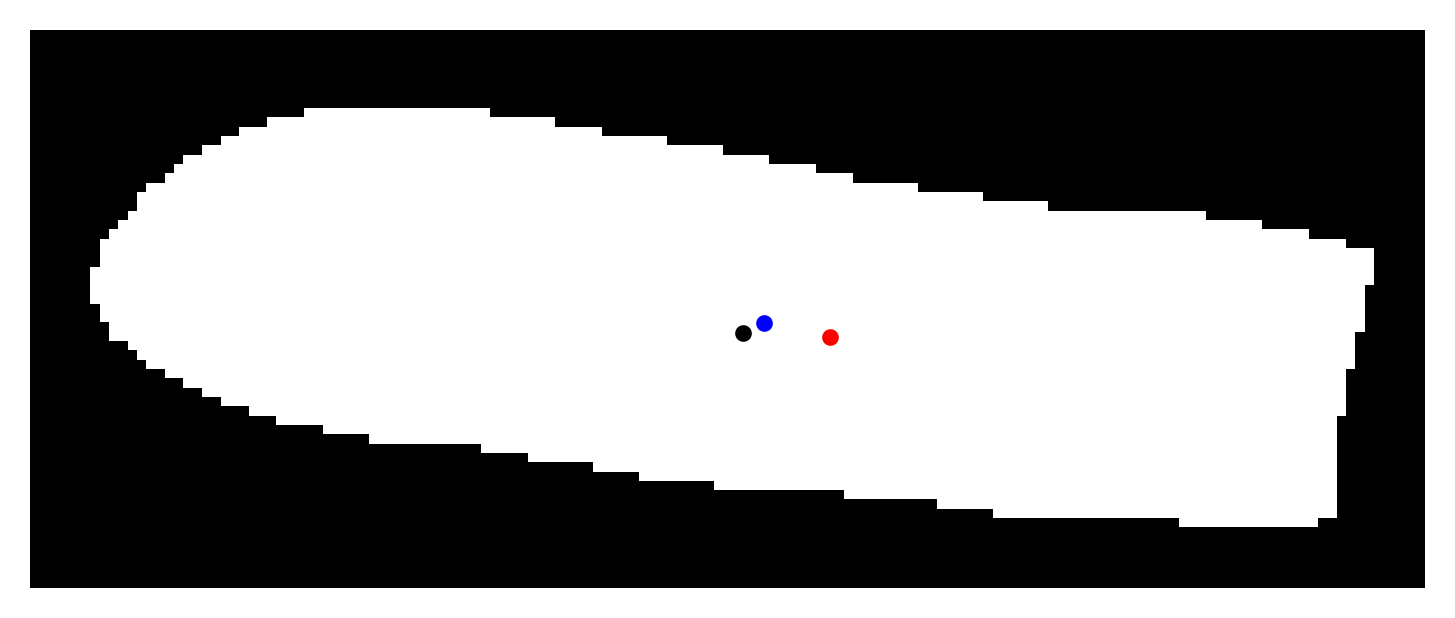

In [90]:
center = cof

plt.imshow(mask,cmap='gray')
plt.plot(cof[0],cof[1],'r.')
plt.plot(comm[0],comm[1],'b.')
plt.plot(comh[0],comh[1],'k.')
plt.xlim([35,185])
plt.ylim([145,85])
plt.axis('off')

## Divide the mask in two

In [59]:
[x,y]=out

(35.0, 185.0, 145.0, 85.0)

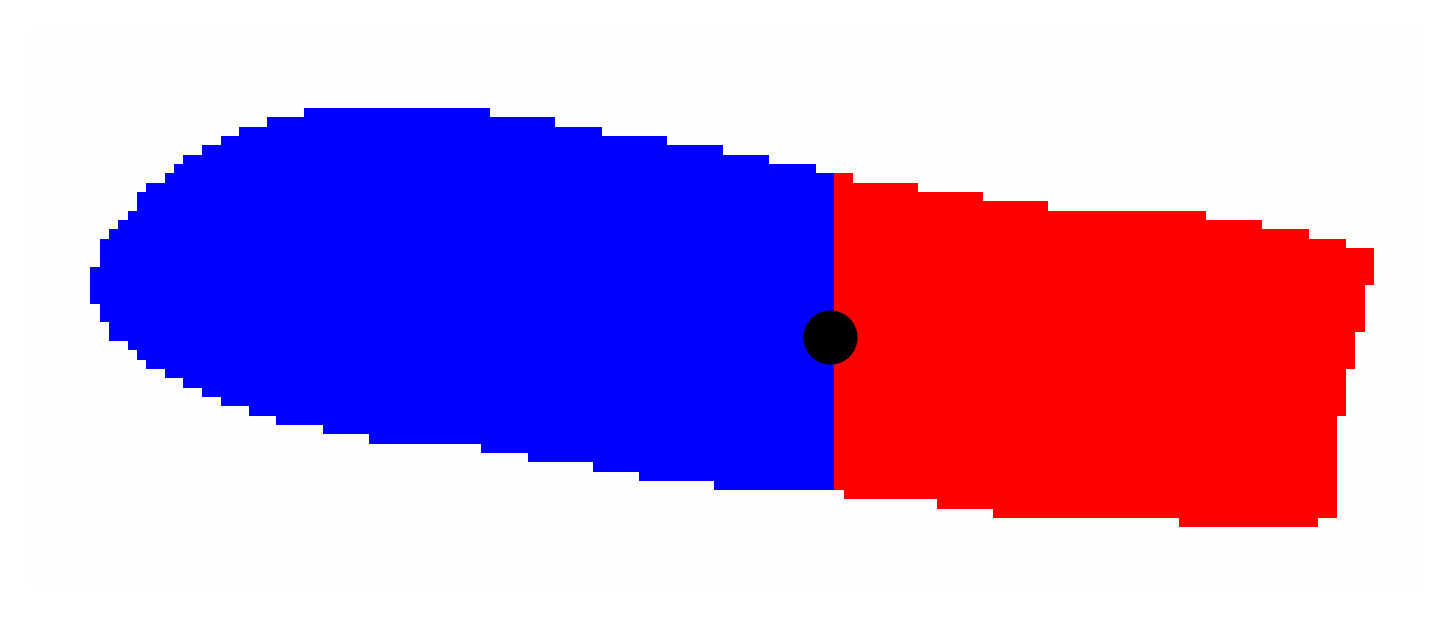

In [83]:
# divide the mask horizontally about the center
d = np.floor(center[0]).astype(int)
(m,n)=np.shape(mask)
sides = np.hstack([np.ones((m,d+1))*(-1),np.ones((m,n-d-1))])
plt.imshow(sides*mask,cmap='bwr')
plt.plot(center[0],center[1],'k.',markersize=24)
plt.xlim([35,185])
plt.ylim([145,85])
plt.axis('off')

In [84]:
rad = dist_function(out[0],out[1],center)
#get separate lists of all points on the outline and their radii for each half of the cell
right=np.vstack([(out[0]>d).astype(np.uint8),(out[0]>d).astype(np.uint8),(out[0]>d).astype(np.uint8)])*np.vstack([out,rad])
left=np.vstack([(out[0]<=d).astype(np.uint8),(out[0]<=d).astype(np.uint8),(out[0]<=d).astype(np.uint8)])*np.vstack([out,rad])

## Find all local maxima of the distance function

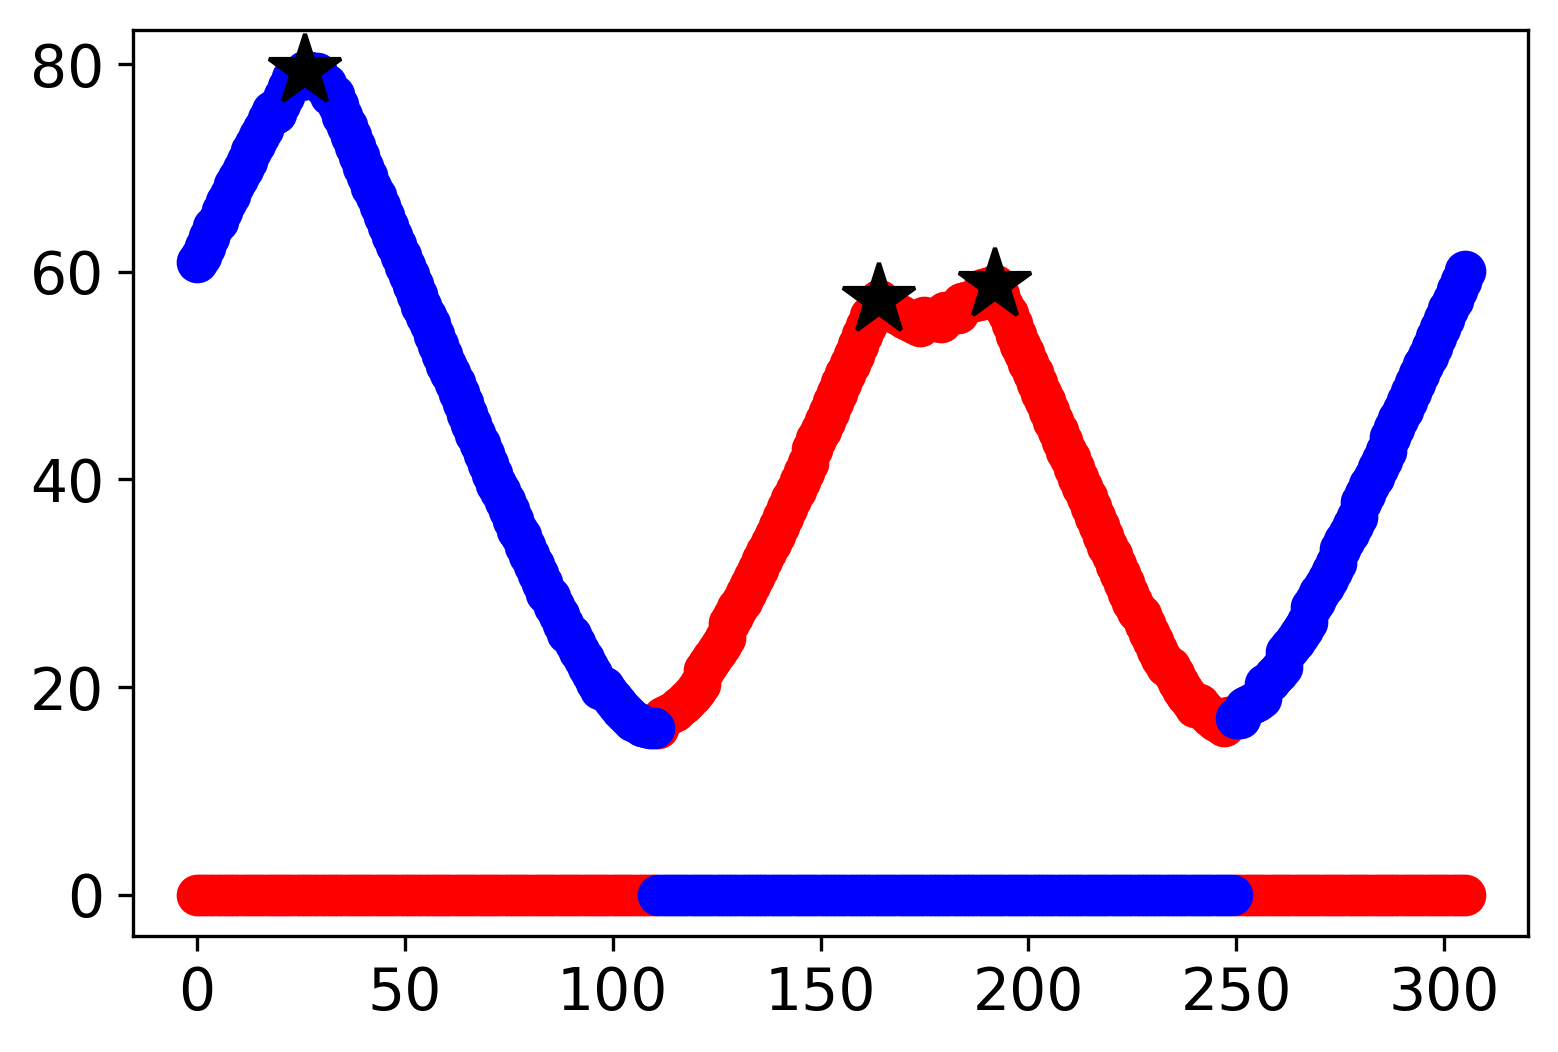

In [85]:
# find the all local max
maxr=argrelmax(rad,order=10,mode='wrap')[0]

# plot on the distance function
plt.plot(right[2],'r.',markersize=18)
plt.plot(left[2],'b.',markersize=18)
plt.plot(maxr,rad[maxr],'k*',markersize=18)

(35.0, 185.0, 145.0, 85.0)

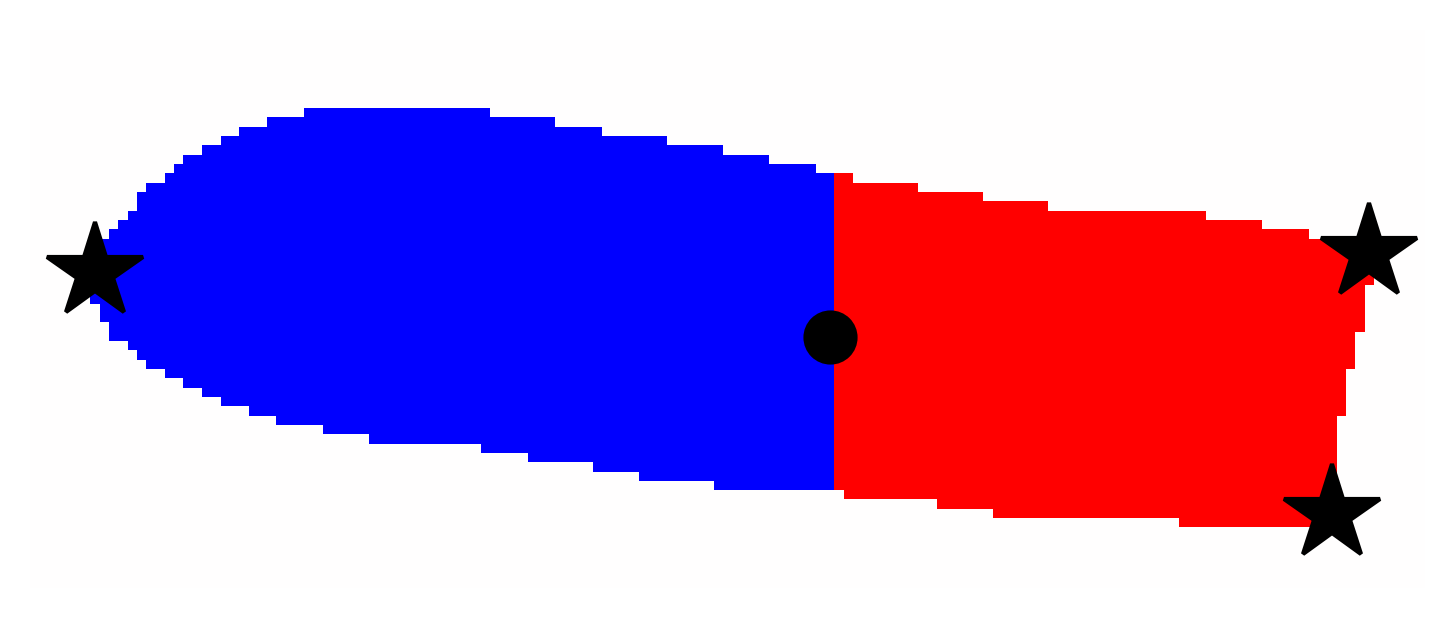

In [86]:
# plot the local maxima on the mask
plt.imshow(sides*mask,cmap='bwr')
plt.plot(center[0],center[1],'k.',markersize=24)
plt.plot(right[0][maxr],right[1][maxr],'k*',markersize=24)
plt.plot(left[0][maxr],left[1][maxr],'k*',markersize=24)
plt.xlim([35,185])
plt.ylim([145,85])
plt.axis('off')

## Find the center of mass of all the local maxima

In [87]:
# find the center of mass of pixels with maximal radius (mass is the distance of the pixel to the center)
left_pole = np.array([np.sum(left[2][maxr]*left[0][maxr]),np.sum(left[2][maxr]*left[1][maxr])])/np.sum(left[2][maxr])
right_pole = np.array([np.sum(right[2][maxr]*right[0][maxr]),np.sum(right[2][maxr]*right[1][maxr])])/np.sum(right[2][maxr])

(35.0, 185.0, 145.0, 85.0)

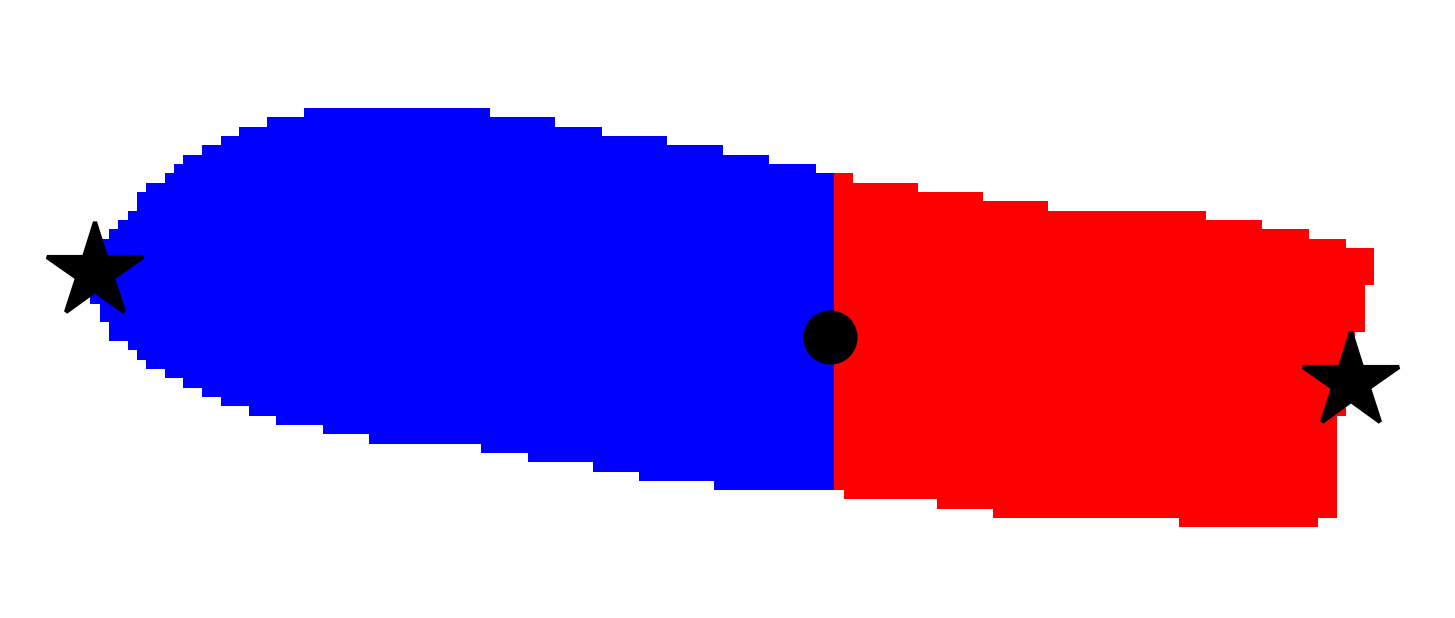

In [88]:
(m,n)=np.shape(mask)
sides = np.hstack([np.ones((m,d+1))*(-1),np.ones((m,n-d-1))])
plt.imshow(sides*mask,cmap='bwr')
plt.plot(center[0],center[1],'k.',markersize=24)
plt.plot(left_pole[0],left_pole[1],'k*',markersize=24)
plt.plot(right_pole[0],right_pole[1],'k*',markersize=24)
plt.xlim([35,185])
plt.ylim([145,85])
plt.axis('off')